In [1]:
import eval
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import train
import torchvision

/home/jpinkney/miniconda3/envs/clip2latent/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
cfg_file = "best.yaml"
checkpoint = "best.ckpt"

cfg = OmegaConf.load(cfg_file)

G, clip_model, trainer = train.load_models(cfg, device)
trainer.load_state_dict(torch.load(checkpoint, map_location="cpu")["state_dict"], strict=False)
diffusion_prior = trainer.ema_diffusion_prior.ema_model

In [22]:
# !wget https://i.pinimg.com/originals/40/67/9b/40679b07f9f697ce6f33071b7980db1d.png
# !wget https://image.shutterstock.com/image-illustration/illustration-face-cute-little-girl-260nw-156562376.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Danny_DeVito_cropped_and_edited_for_brightness.jpg/640px-Danny_DeVito_cropped_and_edited_for_brightness.jpg

--2022-06-10 17:13:11--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Danny_DeVito_cropped_and_edited_for_brightness.jpg/640px-Danny_DeVito_cropped_and_edited_for_brightness.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95514 (93K) [image/jpeg]
Saving to: ‘640px-Danny_DeVito_cropped_and_edited_for_brightness.jpg’

640px-Danny_DeVito_ 100%[===================>]  93.28K  --.-KB/s    in 0.09s   

2022-06-10 17:13:11 (1022 KB/s) - ‘640px-Danny_DeVito_cropped_and_edited_for_brightness.jpg’ saved [95514/95514]



In [25]:
im = Image.open("640px-Danny_DeVito_cropped_and_edited_for_brightness.jpg").resize((224,224))
from torchvision import transforms
inp = transforms.ToTensor()(im)[:3,...]
inp.shape

torch.Size([3, 224, 224])

In [30]:

n_samples = 16
truncation = 1
cond_scale = 1
diffusion_prior.eval()
diffusion_prior.set_timestep_skip(1)
with torch.no_grad():
    text_features = clip_model.embed_image(2*inp.unsqueeze(0).to(device) - 1)
    text_features = text_features.repeat_interleave(n_samples, dim=0)
    pred_w = diffusion_prior.sample(text_features, cond_scale=cond_scale, show_progress=True, truncation=truncation)
    images = G.synthesis(pred_w)
grid = torchvision.utils.make_grid(images.clamp(-1,1), nrow=4, value_range=(-1,1), normalize=True)
grid = 255*grid.permute(1,2,0).cpu()

sampling loop time step: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.14it/s]


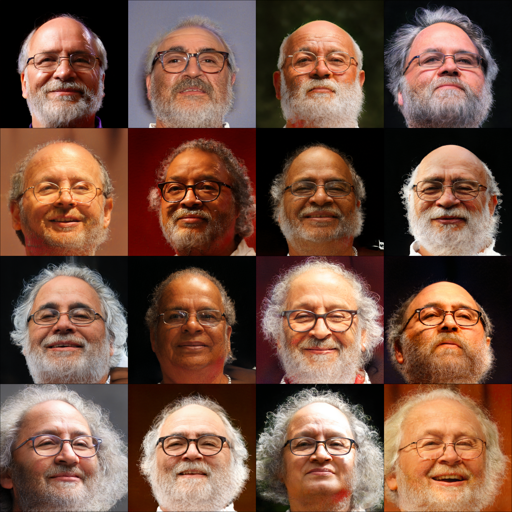

In [31]:
Image.fromarray(grid.numpy().astype(np.uint8)).resize((512,512))